# Modèles statistiques multivariés

La transformée de Fourier nous permet de déceler des saisonnalités cachées dans nos données, et est bien utile pour choisir la saisonnalité d'un modèle SARIMA. 

Cependant, de nombreux phénomènes ont plusieurs saisonnalités et des patterns plus complexes.

Pour reprendre l'exemple de la consommation électrique en Allemagne : 

- saisonnalité journalière (heures pleines vs heures creuses)
- saisonnalité hebdomadaire (weekends vs jours ouvrés)
- saisonnalité annuelle (été vs hiver)
- ...

D'autre part, ces variations peuvent s'expliquer par d'autres facteurs : 
- température
- prix de l'électricité 
- ...

Pour capturer ces variations, on utilise des **modèles multivariés**, c'est-à-dire des modèles qui prennent en compte plusieurs variables.

Typiquement, les données d'entrées ressemblent à ça : 

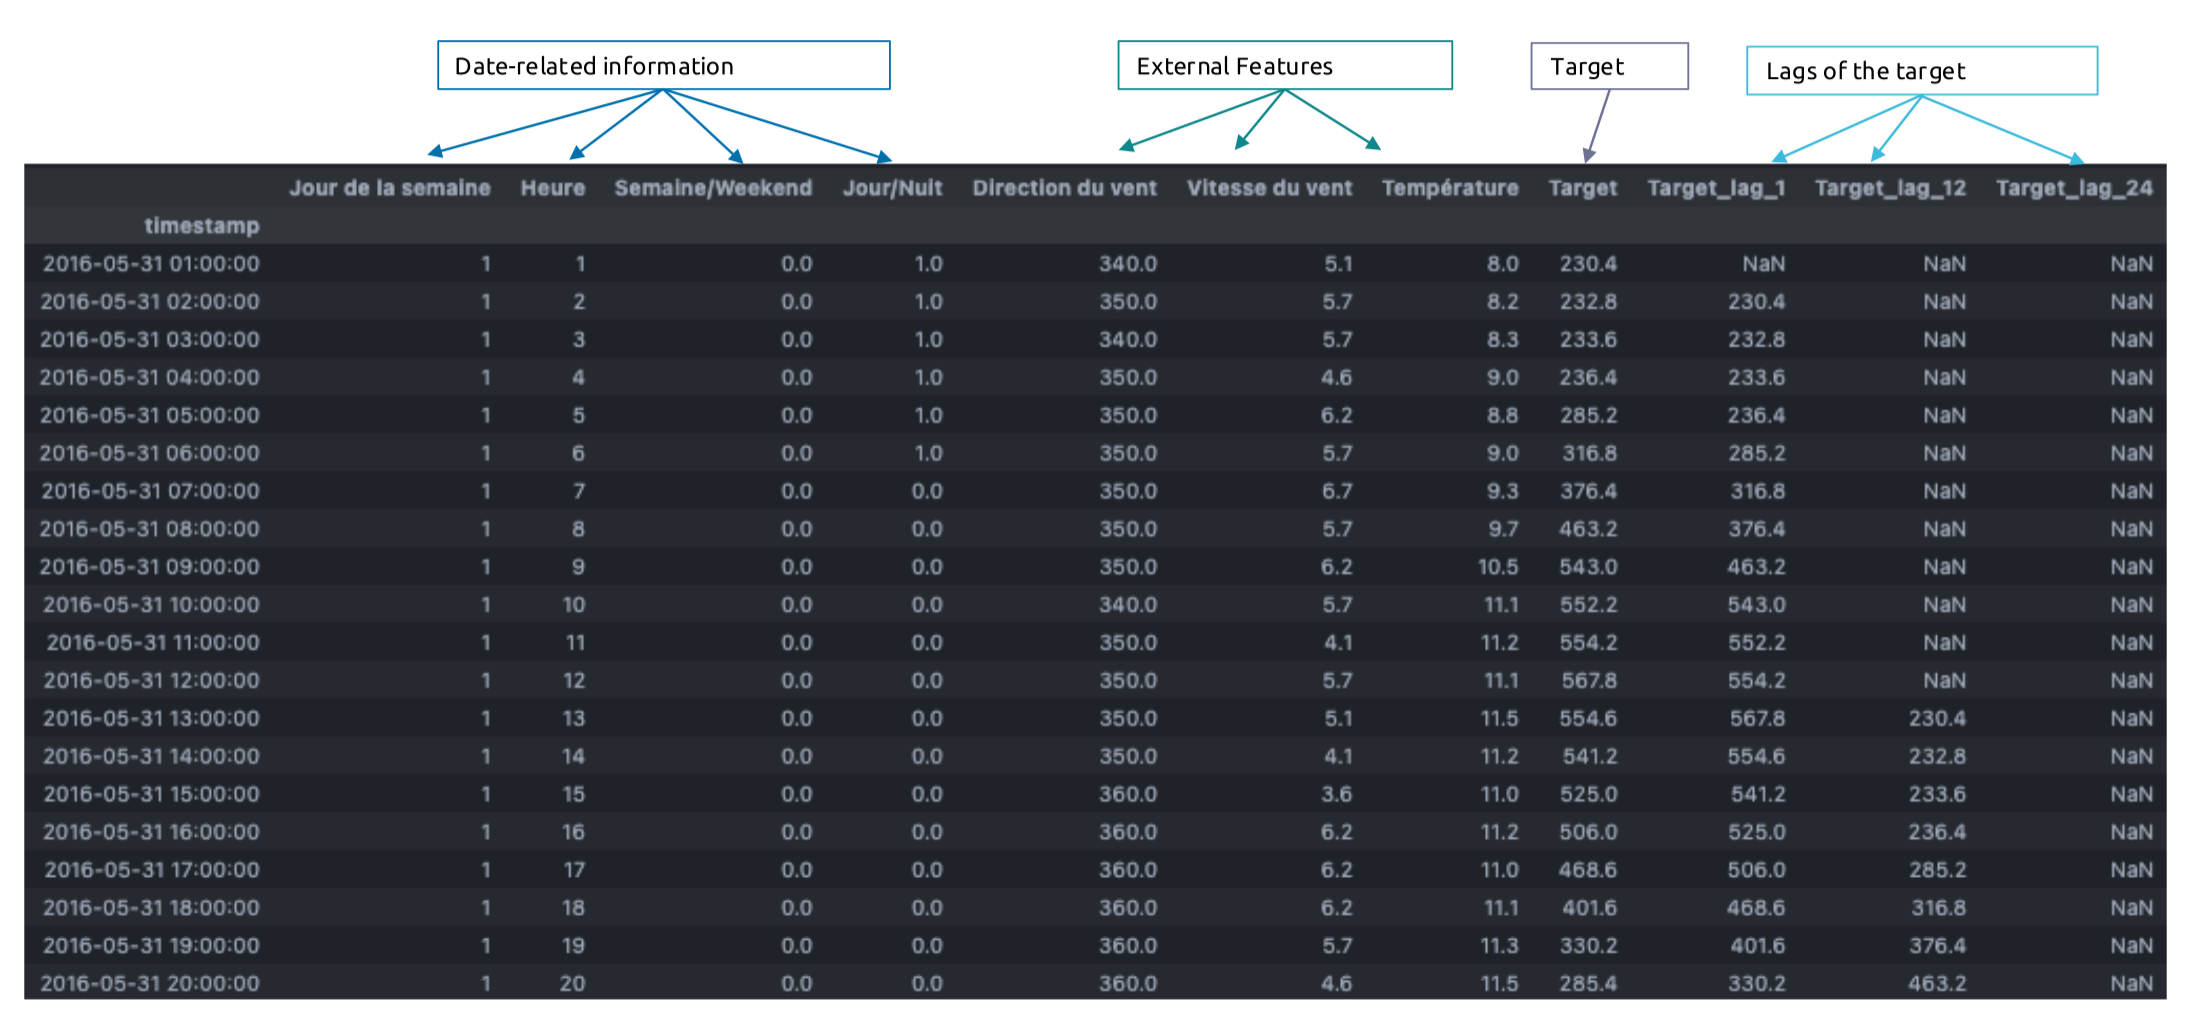

## Modèles multivariés classiques 

Il y a ceux que vous connaissez déjà : 

- Régression Linéaire / Lasso / Ridge / Elasticnet

Les extensions de ceux que vous venez d'apprendre : 

- ARIMA**X** / SARIMA**X** / ARMA**X**

Et ceux que vous verrez bientôt :

- RandomFOrest, XGBoost, Prophet, LTSM ...



## Feature engineering pour les séries temporelles

Classiquement on performe une EDA (plots des moyennes par jour / semaine ..., Transformée de Fourier ...), si l'EDA semble indiquer une relation intéressante, on en fait une feature avec : 

-  `OneHotEncoding` : isweekend / is holidays ...
-  Termes de Fourier
-  statistiques de lag (moyenne / vol glissante, valeurs des lags)
-  Encodage cyclique , voir [docsklearn](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html) 
-  autres encodings (polynomial, interaction ...)

## Modélisation

On peut ensuite suivre le cycle classique de modélisation : 

- choix d'un ou plusieurs modèle 
- grid search des hyperparamètres du modèle, des transformations
- validation du modèle 
- prédiction

## Exercice pratique

### 1. Chargement des données et EDA

In [76]:
import pandas as pd
df = pd.read_csv("data_beijing_cleaned.csv")
df

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,NW,231.97,0,0,2014-12-31 19:00:00
43820,10.0,-22,-3.0,1034.0,NW,237.78,0,0,2014-12-31 20:00:00
43821,10.0,-22,-3.0,1034.0,NW,242.70,0,0,2014-12-31 21:00:00
43822,8.0,-22,-4.0,1034.0,NW,246.72,0,0,2014-12-31 22:00:00


Convertissez la colonne date en type `datetime` et mettez là en index de la df. 
Spécifiez la fréquence (horaire) de l'index.

In [77]:
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

Affichez la target

<Axes: xlabel='date'>

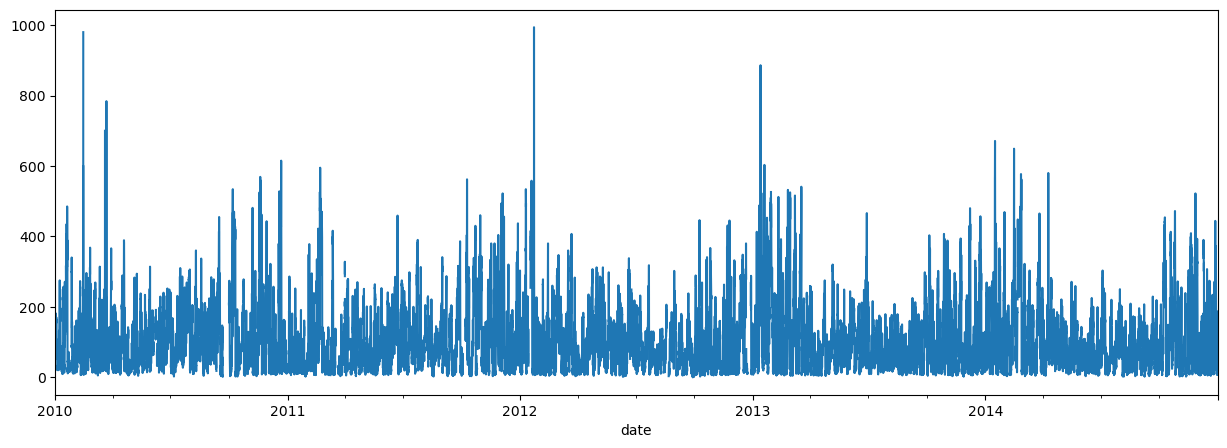

In [78]:
df["pm2.5"].plot(figsize=(15, 5))

Remplacez les valeurs manquantes

In [79]:
df.bfill(inplace=True)

<Axes: xlabel='date'>

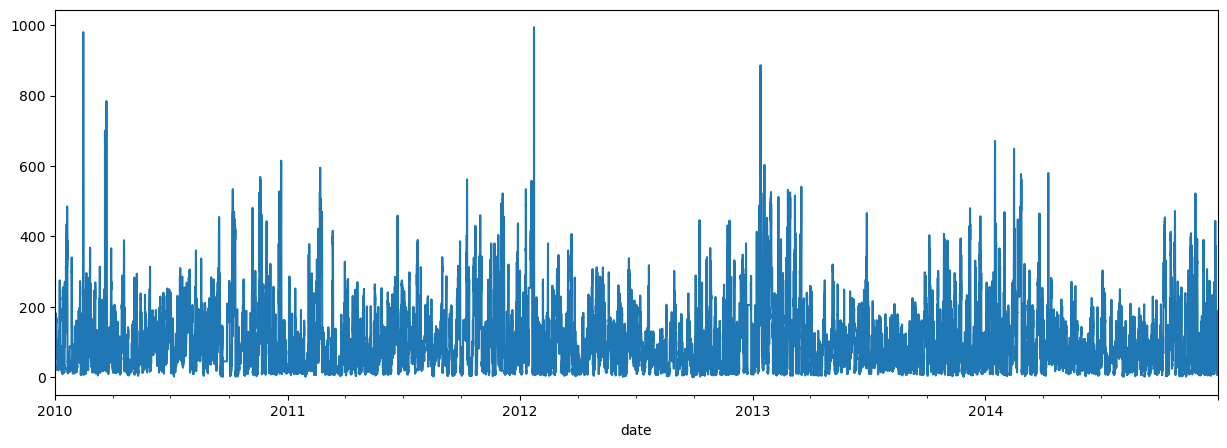

In [80]:
df["pm2.5"].plot(figsize=(15, 5))

La série est elle stationnaire ? 

In [81]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["pm2.5"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -20.994474481842694
p-value: 0.0


Stabiliser la variance avec une transformation Yeo-Johnson

<Axes: xlabel='date'>

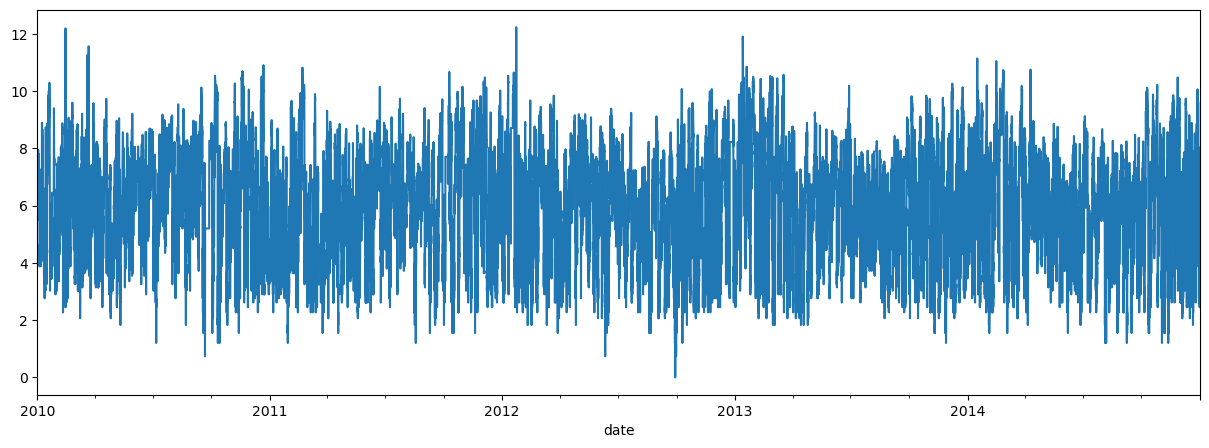

In [82]:
from scipy.stats import yeojohnson

df["pm2.5_transformed"], _ = yeojohnson(df["pm2.5"])

df["pm2.5_transformed"].plot(figsize=(15, 5))

Créez les features suivantes avec pandas: 

- dayofweek
- hour
- month
- season 

[ça peut vous aider de regarder ça](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components)

Affichez les tendances par mois et par heure

Est ce qu'il y a de la saisonnalité ? 

(0.0, 10000.0)

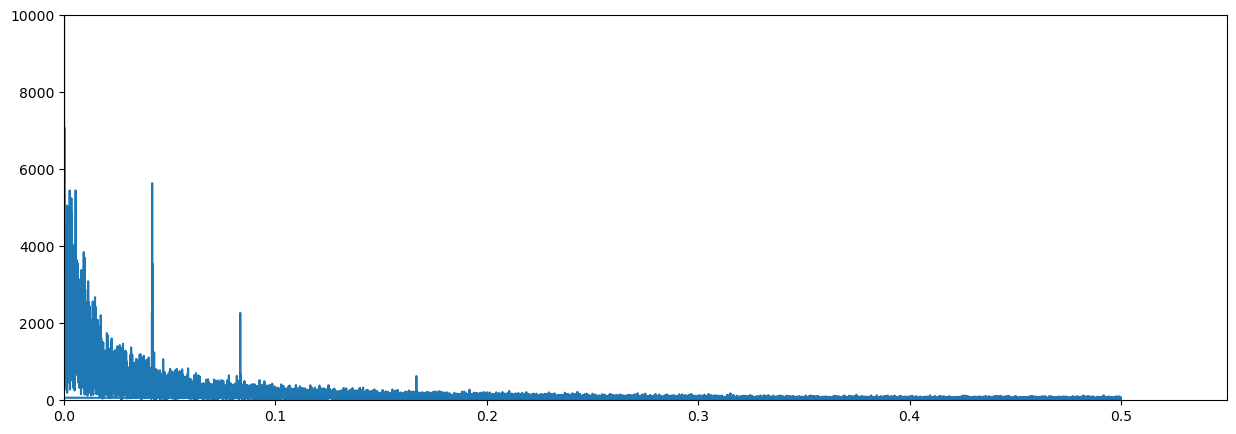

In [ ]:
signal = df["pm2.5_transformed"]

# fft 
fft_values = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(fft_values))
magnitude = np.abs(fft_values)

# plot
plt.figure(figsize=(15, 5))
plt.plot(frequencies, magnitude)
plt.xlim(0)
plt.ylim(0, 10000)

### 2. Modélisation univariée

Pour l'instant on ne s'intéresse qu'à prédire pm2.5_transformed

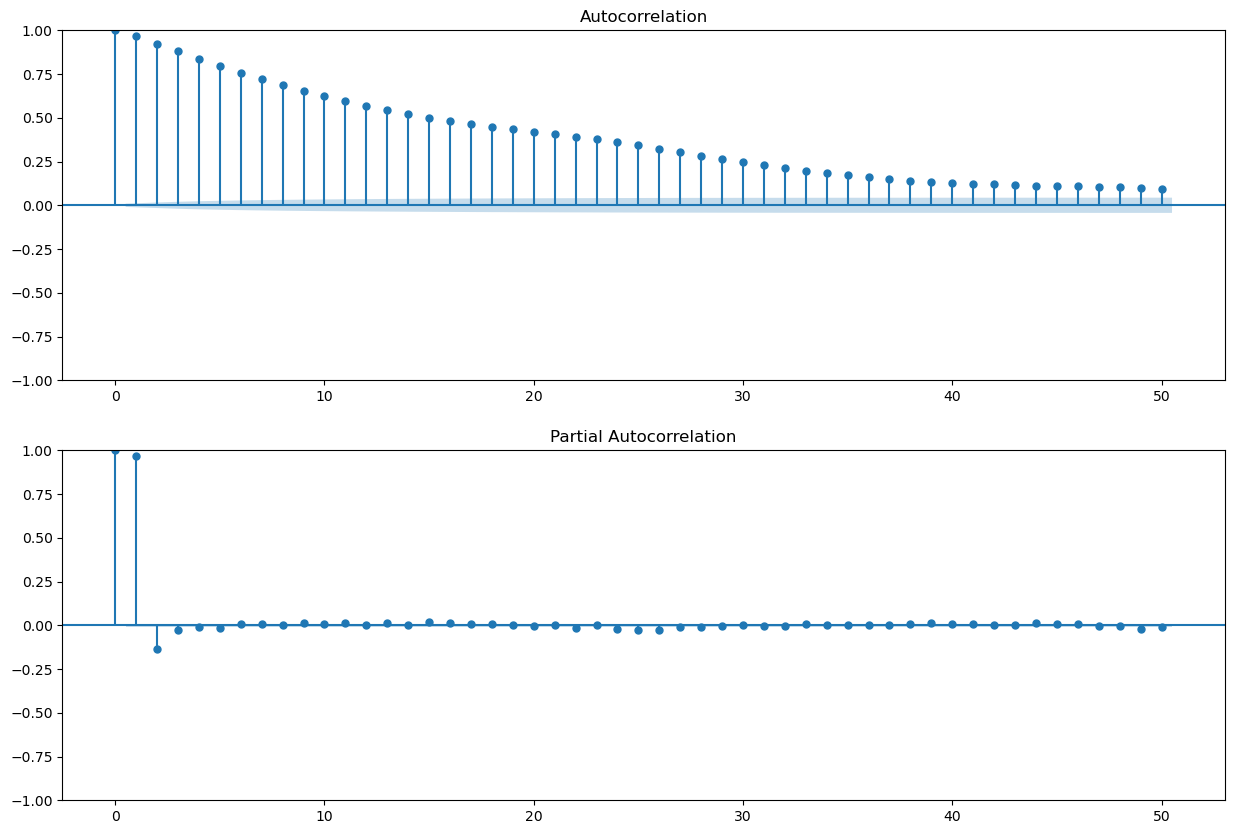

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(df["pm2.5_transformed"], lags=50, ax=axs[0])
plot_pacf(df["pm2.5_transformed"], lags=50, ax=axs[1])
plt.show()

Quel modèle comptez vous choisir ? 

In [ ]:
## votre réponse ici

Séparez votre jeu de données entre ensemble d'apprentissage et ensemble de test (80, 20)

**Gardez la même random seed pour pouvoir comparer les résultats entre vous !**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

Performez une grid search CV en testant différents hyperparamètres sur votre modèle. 

- Attention au choix de votre schéma de CV.

- Vous pouvez utiliser la mae comme méthode de scoring de votre GridSearch

- Vous pouvez créer un modèle `sklearn`compatible avec cette logique (je ne garantis pas que ce soit le meilleur modèle ....)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.base import BaseEstimator, RegressorMixin

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1,1,1), seasonal_order=(1,1,1,24)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_ = None
        self.results_ = None

    def fit(self, X, y=None):
        # SARIMAX attend une série 1D
        self.model_ = SARIMAX(X, order=self.order, seasonal_order=self.seasonal_order)
        self.results_ = self.model_.fit(disp=False)
        return self

    def predict(self, X):
        # X n'est pas utilisé, on prédit sur la longueur de X
        n_steps = len(X)
        forecast = self.results_.get_forecast(steps=n_steps).predicted_mean
        return forecast


In [ ]:
cv = ...

grid_params = ...



grid_search = ...

    # pensez au n_jobs pour accélérer les calculs !


grid_search.fit(X_train, y_train)

Quel est le meilleur modèle obtenu ? Quel est son score ? 

In [ ]:
best_model = 


print("Best parameters:", best_model.best_params_)
print("Best CV score:", best_model.best_score_)

Tracez les prédictions du modèle sur l'ensemble d'entraînement et de test

In [ ]:
y_pred_train = 
y_pred_test =  

plt.plot(y_train.index, y_train, label="Train true", alpha=0.5)
plt.plot(y_train.index, y_pred_train, label="Train pred", color="orange")
plt.plot(y_test.index, y_test, label="Test true", alpha=0.5)
plt.plot(y_test.index, y_pred_test, label="Test pred", color="red")
plt.legend()
plt.show()

Diagnostiquez les résidus sur l'ensemble d'entraînement ? Voyez vous une structure ? 

In [ ]:
y_pred_train = 

residus = y_train - y_pred_train
plt.figure(figsize=(15, 5))
plt.plot(residus, label="Résidus")
plt.legend()
plt.show()

### 3. Modélisation multivariée

Vous pouvez reprendre la df complète et tenter de modéliser `pm2.5_transformed` avec les autres variables. 

Comparez les performances d'une régression linéaire multivariée avec un ElasticNet dont vous aurez grid-searché les meilleurs hyperparamètres. 

*En fin de séance ou chez vous selon le temps* : essayer d'améliorer votre score sur l'ensemble d'entraînement en créant de nouvelles features ou en testant de nouveaux modèles : attention à l'overfitting ! 

**Que le meilleur gagne !**